<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#Varying-V" data-toc-modified-id="Varying-V-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Varying V</a></span></li><li><span><a href="#Plot-both-optimizers" data-toc-modified-id="Plot-both-optimizers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot both optimizers</a></span></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$

This leads to a spectrum of $E_0^{\pm} = \pm(\epsilon_0 + \epsilon_1)/2$, $E_1^{\pm} = \pm \sqrt{\epsilon^2 + 4V^2}/2$, where $\epsilon^2 = (\epsilon_0 - \epsilon_1)^2$.
The eigenvalues are calculated in this [notebook](https://colab.research.google.com/drive/18IyDfCYlMx957260MSwvJtUeTcAJFnza?usp=sharing):

[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [1]:
import sys
sys.path.append('../../')

# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal

# VOLTA
from VOLTA.VQD import VQD
from VOLTA.utils import classical_solver
from VOLTA.Hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

In [19]:
EPSILONS = [3, 3]
V = -2.
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  1.5 * ZI,
  1.5 * IZ,
  -1.0 * XX,
  -1.0 * YY
])


In [20]:
eigenvalues, eigenvectors = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-3. -2.  2.  3.]


# Varying V

In [35]:
from tqdm import tqdm

def hamiltonian_varying_V(min_V, max_V, points, epsilons, n_trials):
    solution_VQD = {}
    energies_Classical = []
    
    V = np.linspace(min_V, max_V, points)
    
    backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                              shots=10000)
    
    optimizer = SPSA(maxiter=250, c1=.5, last_avg=25) 
    #optimizer = COBYLA()
    
    for v in tqdm(V):
        hamiltonian = BCS_hamiltonian(epsilons, v)
        ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=3)
        
        es_1 = []
        es_2 = []

        for _ in tqdm(range(n_trials), desc=f"V= {v}"):

            # Run algorithm
            Algo = VQD(hamiltonian=hamiltonian,
                        ansatz=ansatz,
                        n_excited_states=2,
                        beta=10.,
                        optimizer=optimizer,
                        backend=backend)

            Algo.run(0)      
            vqd_energies = Algo.energies
            es_1.append(vqd_energies[1])
            es_2.append(vqd_energies[2])
        es_1 = np.array(es_1)
        es_2 = np.array(es_2)
    
        solution_VQD[v] = {'mean':np.mean(es_2 - es_1), 'std':np.std(es_2 - es_1)}
        
        classical, _ = classical_solver(hamiltonian)
        energies_Classical.append(classical[2]- classical[1])
    
    return solution_VQD, np.array(energies_Classical), V

In [36]:
min_V = -0.
max_V = -2.
points = 5
epsilons = [3,3]
n_trials = 50
solution_VQD, energy_classical, V = hamiltonian_varying_V(min_V, max_V, points, epsilons, n_trials)

V= -1.0:  60%|██████    | 30/50 [4:16:23<2:07:51, 383.57s/it]


100%|██████████| 5/5 [34:51:06<00:00, 24106.41s/it]  4s/it]


In [37]:
solution_VQD

{-0.0: {'mean': 2.2544600000000004, 'std': 3.6059371187529052},
 -0.5: {'mean': 2.201132, 'std': 3.5924339523749076},
 -1.0: {'mean': 2.3685160000000005, 'std': 3.2362400972956262},
 -1.5: {'mean': 2.262069, 'std': 3.6215824729514305},
 -2.0: {'mean': 2.151896, 'std': 3.285247713884601}}

In [38]:
import seaborn as sns
sns.set()

In [39]:
mean = []
std = []
for _, sol in solution_VQD.items():
    mean.append(sol['mean'])
    std.append(sol['std'])

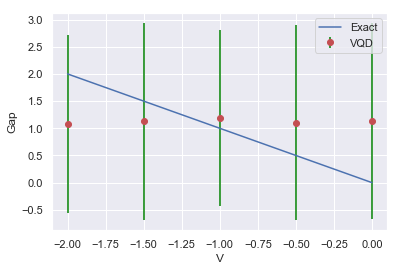

In [40]:
plt.errorbar(V,
             np.array(mean)/2, 
             yerr=np.array(std)/2,
             fmt='ro', ecolor='green',
             label='VQD')

plt.plot(V, energy_classical/2, 'b-', label="Exact")
plt.xlabel('V')
plt.ylabel('Gap')
plt.legend()
plt.savefig('Var_V.png')
plt.show()

# Plot both optimizers

In [51]:
V

array([-0. , -0.5, -1. , -1.5, -2. ])

In [52]:
spsa_dict = {-0.0: {'mean': 2.2544600000000004, 'std': 3.6059371187529052},
 -0.5: {'mean': 2.201132, 'std': 3.5924339523749076},
 -1.0: {'mean': 2.3685160000000005, 'std': 3.2362400972956262},
 -1.5: {'mean': 2.262069, 'std': 3.6215824729514305},
 -2.0: {'mean': 2.151896, 'std': 3.285247713884601}}


cobyla_dict = {-0.0: {'mean': 0.2738039999999999, 'std': 0.5017597014348602},
 -0.5: {'mean': 1.1608589999999999, 'std': 0.7228235554884747},
 -1.0: {'mean': 2.0350799999999993, 'std': 0.8327042377699295},
 -1.5: {'mean': 3.137112, 'std': 0.6724548732487554},
 -2.0: {'mean': 4.314758, 'std': 0.5284894406097439}}

mean_spsa = []
std_spsa = []
mean_cobyla = []
std_cobyla = []

x_axis = np.array([-0. , -0.5, -1. , -1.5, -2. ])
for sol in x_axis:
    mean_spsa.append(spsa_dict[sol]['mean'])
    std_spsa.append(spsa_dict[sol]['std'])
    
    mean_cobyla.append(cobyla_dict[sol]['mean'])
    std_cobyla.append(cobyla_dict[sol]['std'])

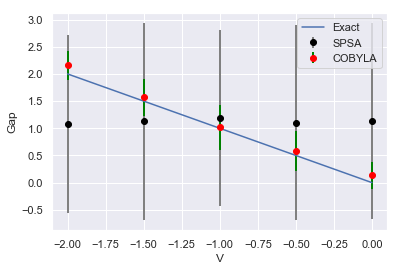

In [54]:
from matplotlib.ticker import MaxNLocator

x_axis = np.array([-0. , -0.5, -1. , -1.5, -2. ])
energy_classical = np.array([0., 1., 2., 3., 4.])

plt.errorbar(x_axis,
             np.array(mean_spsa)/2, 
             yerr=np.array(std_spsa)/2,
             fmt='o', color='black', 
             ecolor='gray', elinewidth=2,
             label='SPSA')

plt.errorbar(x_axis,
             np.array(mean_cobyla)/2, 
             yerr=np.array(std_cobyla)/2,
             fmt='o', color='red',
             ecolor='green', elinewidth=2,
             label='COBYLA')

plt.plot(V, energy_classical/2, 'b-', label="Exact")
plt.xlabel('V')
plt.ylabel('Gap')
plt.legend()
plt.savefig('Var_V_optimizers.png')
plt.show()